In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
import pandas as pd
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import time
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans



In [ ]:
#Para extraer los features del audio
def extract_feature(file_name):
  x, sample_rate = librosa.load(file_name)

  stft = np.abs(librosa.stft(x))

  result = np.array([])

  #mfcc
  mfccs = np.mean(librosa.feature.mfcc(y=x, sr=sample_rate).T, axis=0)
  result = np.hstack((result, mfccs))

  #chroma
  chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis = 0)
  result = np.hstack((result, chroma))

  #spectrograma de mel
  mel = np.mean(librosa.feature.melspectrogram(x, sr=sample_rate).T, axis = 0)
  result = np.hstack((result, mel))
  return result

In [ ]:
#Para cargar los datos del Drive Compartido
def load_data():
  x = []
  labels_x = []

  for file in glob.glob("/content/drive/Shareddrives/Reconocimiento de Voz Drive/AudioData/*/*.wav"):
    file_name = os.path.basename(file)
    feature = extract_feature(file)
    labels_x.append(file_name[:-6])
    x.append(feature)

  return np.array(x),np.array(labels_x)

In [ ]:
#cargamos y extraemos los features de los audios
#ademas se extrae las etiquetas para poder realizar la validacion
X,label_x = load_data()

In [ ]:
#verificamos la cantidad de emociones
codes = np.unique(label_x)
print(codes)
print(len(codes))

['a' 'd' 'f' 'h' 'n' 'sa' 'su']
7


In [ ]:
#El primer numero nos muestra el numero de archivos que tenemos
#Y el segundo imprime el numbero de features/characteristicas que tiene los archivos
print(X.shape)

(480, 160)


In [ ]:
def shuffle_data(X_scl, codes):

    # Pondremos a un lado el conjunto de prueba 
    # No los tocaremos hasta el final.
    X_train, X_test, y_train, y_test = train_test_split(X_scl, codes, test_size=1, random_state=728)
    return X_train, y_train

In [ ]:
#Conjunto de entrenamiento randomisao (mescla de muestras)
X, y_train = shuffle_data(X, label_x)

In [ ]:
#Estandarizamos nuestros datos con la clase de estanderacion StandardScaler()
scaler = StandardScaler()
X_scl = scaler.fit_transform(X)
print(f'feature: {X_scl.shape[1]}')

feature: 160


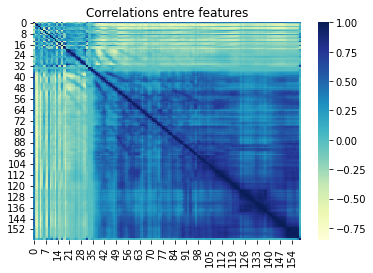

In [ ]:
#Mostramos la relacion entre caracteristica
sns.heatmap(pd.DataFrame(X_scl).corr(), cmap="YlGnBu").set(title="Correlations entre features");

In [ ]:
#Con la funcion PCA() obtenemos la relacion de la varianzia explicado para luego poder sacar
#los features mas importantes
pca = PCA()
pca.fit(X_scl);

evr = pca.explained_variance_ratio_
evr

array([4.40371628e-01, 6.97757319e-02, 5.05624846e-02, 4.33761158e-02,
       3.60146503e-02, 2.61119941e-02, 2.29123703e-02, 2.15586439e-02,
       1.80230393e-02, 1.62990127e-02, 1.58123204e-02, 1.54792820e-02,
       1.30464329e-02, 1.22989399e-02, 1.19951484e-02, 9.58402036e-03,
       9.26099413e-03, 9.09526700e-03, 8.20136877e-03, 7.31891690e-03,
       6.86381573e-03, 6.17108190e-03, 6.00949559e-03, 5.78447567e-03,
       5.54487869e-03, 5.46754918e-03, 5.34042732e-03, 4.85873381e-03,
       4.69911576e-03, 4.23252576e-03, 4.08574033e-03, 3.75554667e-03,
       3.58701384e-03, 3.54378523e-03, 3.20821765e-03, 3.12695725e-03,
       3.05459937e-03, 2.83020797e-03, 2.67931066e-03, 2.55873612e-03,
       2.38010281e-03, 2.32517717e-03, 2.22665158e-03, 2.14754004e-03,
       1.98822164e-03, 1.97141443e-03, 1.91269061e-03, 1.72299637e-03,
       1.65943315e-03, 1.61134599e-03, 1.54900810e-03, 1.50024780e-03,
       1.46434333e-03, 1.39635054e-03, 1.38495070e-03, 1.29181261e-03,
      

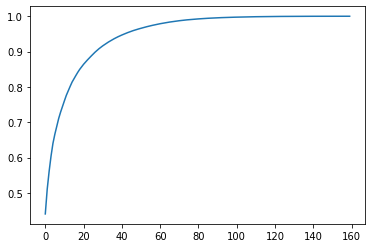

In [ ]:
# para trazar la varianza explicativa acumulativa de los componentes de PCA
# Esto nos ayudará a decidir cuántos componentes debemos reducir en nuestras funciones#
plt.plot(np.cumsum(evr))

In [ ]:
#Con el metodo cumsum() evaluamos cada feature su valor de
# relacion de la varianzia explicado
#de tal forma filtrando los features mas importantes
for i, exp_var in enumerate(evr.cumsum()):
    if exp_var >= 0.8:
        n_comps = i + 1
        break
print("Number of components:", n_comps)
pca = PCA(n_components = n_comps)
pca.fit(X_scl)
scores_pca = pca.transform(X_scl)
scores_pca.shape

Number of components: 14


(479, 14)

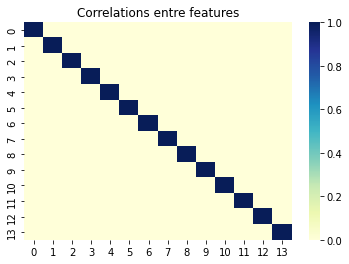

In [ ]:
#relacion entre caracteristicas de pca
sns.heatmap(pd.DataFrame(scores_pca).corr(), cmap="YlGnBu").set(title="Correlations entre features");

In [ ]:
#funcion para crear el modelo de clusters
def create_train_kmeans(data, number_of_clusters=len(codes)):
    k = KMeans(n_clusters=number_of_clusters, random_state=728)

    # Haremos algunos horarios para ver cuánto tiempo lleva entrenar.
    start = time.time()

    # Entrenarlo
    k.fit(data)

    # Detener el tiempo
    end = time.time()

    # Y miramos cuánto tiempo nos tomó esto
    print("Training took {} seconds".format(end-start))
    
    return k

In [ ]:
# Aquí creamos y ajustamos un modelo KMeans con la salida PCA
K_scores_pca = create_train_kmeans(scores_pca)

Training took 0.06600332260131836 seconds


In [ ]:
# Ahora tenemos las predicciones del modelo cluster

# KMeans con salidas PCA
k_pred_pca = K_scores_pca.predict(scores_pca)
k_pred_pca

array([5, 5, 2, 5, 2, 2, 1, 5, 1, 1, 2, 1, 1, 1, 2, 1, 5, 0, 1, 2, 5, 0,
       5, 2, 5, 1, 2, 1, 5, 1, 1, 1, 2, 2, 4, 1, 2, 2, 4, 1, 2, 4, 1, 5,
       2, 1, 0, 1, 1, 2, 1, 1, 2, 1, 1, 5, 0, 6, 5, 5, 5, 5, 0, 1, 2, 5,
       2, 5, 0, 5, 1, 2, 5, 1, 5, 5, 1, 2, 2, 1, 1, 1, 3, 5, 1, 1, 1, 0,
       5, 5, 1, 2, 2, 5, 0, 1, 1, 1, 0, 5, 2, 1, 5, 2, 1, 0, 1, 1, 1, 2,
       5, 2, 0, 1, 2, 5, 2, 5, 2, 5, 1, 2, 1, 1, 5, 5, 1, 0, 2, 0, 4, 1,
       5, 5, 1, 1, 0, 1, 1, 1, 0, 2, 1, 2, 0, 5, 2, 0, 1, 5, 2, 1, 5, 1,
       1, 1, 2, 5, 1, 1, 5, 0, 1, 5, 1, 2, 1, 0, 5, 1, 5, 5, 1, 1, 2, 1,
       1, 1, 1, 5, 0, 1, 5, 1, 5, 1, 0, 2, 1, 2, 5, 5, 2, 5, 1, 5, 5, 1,
       1, 5, 2, 2, 1, 1, 5, 5, 1, 5, 1, 0, 1, 1, 1, 0, 1, 5, 1, 1, 1, 2,
       1, 5, 2, 1, 5, 1, 2, 5, 1, 2, 1, 5, 1, 1, 2, 5, 1, 1, 1, 1, 2, 2,
       5, 1, 5, 0, 2, 1, 0, 1, 2, 2, 2, 1, 0, 1, 1, 0, 1, 2, 5, 1, 0, 0,
       1, 5, 2, 1, 4, 0, 1, 2, 1, 2, 2, 2, 5, 2, 1, 5, 2, 5, 2, 2, 5, 5,
       0, 5, 2, 2, 2, 5, 1, 1, 1, 1, 1, 1, 1, 1, 5,

In [ ]:
#funcion para contar cuántos hay de cada etiqueta por cada grupo
def cluster_label_count(clusters, labels):
    
    count = {}

    # Obtenemos los clusters y las etiquetas
    unique_clusters = list(set(clusters))
    unique_labels = list(set(labels))
    
    #Creamos un contador para cada combinación del clúster 
    #sobre(/) etiqueta  y establecerlo en 0
    for cluster in unique_clusters:
        count[cluster] = {}
        
        for label in unique_labels:
            count[cluster][label] = 0

    for i in range(len(clusters)):
        count[clusters[i]][labels[i]] +=1
    
    cluster_df = pd.DataFrame(count)
    
    return cluster_df

In [ ]:
cluster_count_pca = cluster_label_count(k_pred_pca, y_train)

In [ ]:
#muetra el conteo de las etiquetas por grupo
cluster_count_pca

,0,1,2,3,4,5,6
sa,0,42,15,0,0,3,0
f,13,10,15,0,1,21,0
n,0,90,30,0,0,0,0
su,14,3,15,1,0,27,0
d,1,37,15,0,0,6,0
a,6,3,15,0,9,26,1
h,13,1,15,0,0,31,0


In [ ]:
#ajuste manual para que el índice de cada 
#etiqueta refleje en qué cluster se encuentra
cluster_codes  = ["su","n","sa","d","f","h","a"]

In [ ]:
pred_codes_pca = [cluster_codes[x] for x in k_pred_pca]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [ ]:
#Evaluacion del rendimiento del modelo
def print_scores(true, pred):
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred, average="macro")
    ps = precision_score(true, pred, average="macro")
    rs = recall_score(true, pred, average="macro")
    return "\n\tF1 Score: {0:0.8f}  |  Accuracy: {0:0.8f}   | Precision: {0:0.8f} | Recall: {0:0.8f}".format(f1,acc)

print("KMeans VGG16 (PCA)", print_scores(y_train, pred_codes_pca))

KMeans VGG16 (PCA) 
	F1 Score: 0.20489491  |  Accuracy: 0.20489491   | Precision: 0.20489491 | Recall: 0.20489491
